In [2]:
import ee
import geemap
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Create Map and center on Manauas EC Flux Tower coordinates
Map = geemap.Map(center = (-2.609097222, -60.20929722), zoom = 10)
brma2_point = ee.Geometry.Point(-60.20929722, -2.609097222)
brma2_region = ee.Geometry.Rectangle(-60.50, -2.85, -60.00, -2.35)
Map

Map(center=[-2.609097222, -60.20929722], controls=(WidgetControl(options=['position'], widget=HBox(children=(T…

In [24]:
Map.addLayer(brma2_region, {}, 'Manauas Region')

In [4]:
#Calculate Inverted Red-Edge Chlorophyll Index
def addIreci(image):
    nir = image.select('B8')
    r = image.select('B4')
    re1 = image.select('B5')
    re2 = image.select('B6')
    ireci = nir.subtract(r).divide(re1.divide(re2)).rename('IRECI')
    return image.addBands(ireci)

In [5]:
ireci_params = ({'min': 0.0,'max':10000, 'palette' : 
               ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']})

In [6]:
#Load sentinel-2 data and clip to brma_2; set visual params
s2 = (ee.ImageCollection('COPERNICUS/S2') #Select S2 1-C level data
     .filterBounds(brma2_region) #Grab tiles that intersect Manaus, BR, region
     .filterDate(ee.Date('2016-01-01'), ee.Date('2020-01-01')) #Select year I want
     .sort('CLOUDY_PIXEL_PERCENTAGE', False)
     .map(addIreci)) #calculate IRECI and add as band

In [8]:
#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int()
cirrusBitMask = ee.Number(2).pow(11).int()
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [9]:
#Create a masked collection
masked = s2.map(maskS2clouds)

In [10]:
#Find median NDRE of each month in 2016 and save to image collection
#https://gis.stackexchange.com/questions/301165/how-to-get-monthly-averages-from-earth-engine-in-the-python-api
months = ee.List.sequence(1, 12) #Create a list with nums 1-12
years = ee.List.sequence(2016, 2019)

def byYear(y):
    def byMonth(m):
        return (masked
                .filter(ee.Filter.calendarRange(y, y, 'year'))
                .filter(ee.Filter.calendarRange(m, m, 'month'))
                .qualityMosaic('IRECI')
                .set('month', m).set('year', y))
    return months.map(byMonth)

col = ee.ImageCollection.fromImages(years.map(byYear).flatten())
col = col.map(lambda image: image.clip(brma2_region)).select('IRECI') #Choose JUST NDRE band and clip to region

In [11]:
july2016 = (col
         .filterMetadata('year', 'equals', 2016)
         .filterMetadata('month', 'equals', 7).select('IRECI')) #1 is January, 12 is December
Map.addLayer(july2016, ireci_params, 'July 2016')

In [12]:
#Select July 2018 and 2019 to test
july2018 = (col
         .filterMetadata('year', 'equals', 2018)
         .filterMetadata('month', 'equals', 7).select('IRECI')) #1 is January, 12 is December
Map.addLayer(july2018, ireci_params, 'July 2018')

In [13]:
july2019 = (col
         .filterMetadata('year', 'equals', 2019)
         .filterMetadata('month', 'equals', 7).select('IRECI')) #1 is January, 12 is December
Map.addLayer(july2019, ireci_params, 'July 2019')

In [14]:
dec2019 = (col
         .filterMetadata('year', 'equals', 2019)
         .filterMetadata('month', 'equals', 12).select('IRECI')) #1 is January, 12 is December
Map.addLayer(dec2019, ireci_params, 'Dec 2019')

In [15]:
#For reference
Map.addLayer(brma2_point, {'color': 'red'}, 'EC Flux Site')

In [166]:
count = col.size().getInfo()
print(count)

48


In [16]:
#Functions to calculate stats thanks to Jitu!!!
# Mean
def region_mean_Image(img):
    # mean over all pixels in the region for the image
    return img.set('mean', img.reduceRegion(ee.Reducer.mean(), geometry=brma2_region, scale=20)) 


def region_mean_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_mean_Image)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())

# Median
def region_median_Image(img):
    # mean over all pixels in the region for the image
    return img.set('median', img.reduceRegion(ee.Reducer.median(), geometry=brma2_region, scale=20)) 

def region_median_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_median_Image)
    stats_list = stats.aggregate_array('median')
    return np.array(stats_list.getInfo())

# Stddev
def region_stddev_Image(img):
    # stddev over all pixels in the region for the image
    return img.set('stddev', img.reduceRegion(ee.Reducer.stdDev(), geometry=brma2_region, scale=20)) 

def region_stddev_ImageCollection(ic):
    # stddev over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_stddev_Image)
    stats_list = stats.aggregate_array('stddev')
    return np.array(stats_list.getInfo())

# Percentiles
def region_percentiles_Image(img):
    # 5,10,25,75,90,95 percentiles over all pixels in the region for the image
    return img.set('percentiles', img.reduceRegion(ee.Reducer.percentile([5,10,25,75,90,95]), geometry=brma2_region, scale=20)) #) mean, median, stdDev, percentiles

def region_percentiles_ImageCollection(ic):
    # percentiles over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_percentiles_Image)
    stats_list = stats.aggregate_array('percentiles')
    return np.array(stats_list.getInfo())

In [17]:
#Create list of dictionaries as [{'IRECI': value} ...]
#Note: this takes a while
mean_list = region_mean_ImageCollection(col)
median_list = region_median_ImageCollection(col)
stddev_list = region_stddev_ImageCollection(col)
percentile_list = region_percentiles_ImageCollection(col)

In [18]:
#Create month list
months = list(range(0,48))
months = np.array(months)

In [26]:
def newList(alist):
    list_name = []
    for value in alist:
        if value is not None:
            list_name.append(value['IRECI'])
    return list_name

In [27]:
def p_list(alist):
    p10, p25, p5, p75, p90, p95 = [], [], [], [], [], []
    for value in alist:
        if value is not None:
            p5.append(value['IRECI_p5'])
            p10.append(value['IRECI_p10'])
            p25.append(value['IRECI_p25'])
            p75.append(value['IRECI_p75'])
            p90.append(value['IRECI_p90'])
            p95.append(value['IRECI_p95'])
    return p5, p10, p25, p75, p90, p95

In [28]:
#Make lists for each set of values
mean_ireci = newList(mean_list)
median_ireci = newList(median_list)
stddev_ireci = newList(stddev_list)
percentile_ireci = p_list(percentile_list)

In [22]:
print(len(mean_ireci))

48


In [23]:
#Make lists with +/- SD
plus_error = [x + y for x,y in zip(mean_ireci, stddev_ireci)]
minus_error = [x - y for x,y in zip(mean_ireci, stddev_ireci)]

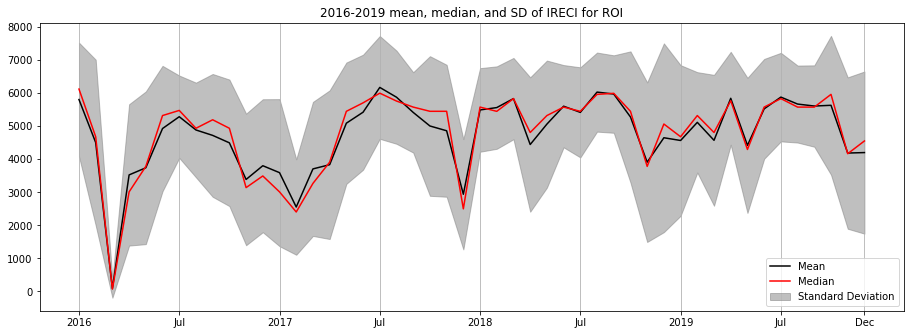

In [24]:
#Plot mean using matplotlib's pyplot
x = months
y = mean_ireci
m = median_ireci
ticks1 = list(range(0,48))
plt.axes([0, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')
plt.title('2016-2019 mean, median, and SD of IRECI for ROI')
plt.fill_between(x, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
mean = plt.plot(x,y, color = "black", label = "Mean")
median = plt.plot(x,m, color = "red", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = ticks1)
plt.xticks(ticks = [0, 6, 12, 18, 24, 30, 36, 42, 47], labels = ['2016', 'Jul', '2017', 'Jul', '2018', 'Jul', '2019', 'Jul', 'Dec'])
plt.show()

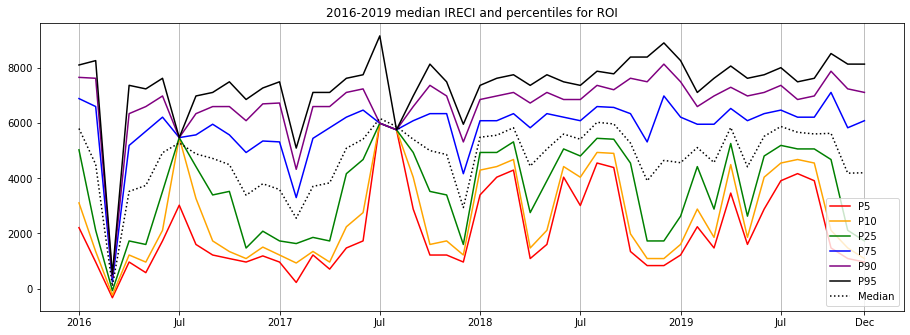

In [25]:
#Plot median using matplotlib's pyplot
x = months
plt.axes([0, 0, 2, 1])
plt.grid(b = True, which = 'major', axis = 'x')
y5 = plt.plot(x,percentile_ireci[0], color = "red", label = "P5")
y10 = plt.plot(x,percentile_ireci[1], color = "orange", label = "P10")
y25 = plt.plot(x,percentile_ireci[2], color = "green", label = "P25")
y75 = plt.plot(x,percentile_ireci[3], color = "blue", label = "P75")
y90 = plt.plot(x,percentile_ireci[4], color = "purple", label = "P90")
y95 = plt.plot(x,percentile_ireci[5], color = "black", label = "P95")
plt.title('2016-2019 median IRECI and percentiles for ROI')
median = plt.plot(x,y, color = "black", linestyle = ":", label = "Median")
plt.legend(loc = "lower right")
plt.xticks(ticks = [0, 6, 12, 18, 24, 30, 36, 42, 47], labels = ['2016', 'Jul', '2017', 'Jul', '2018', 'Jul', '2019', 'Jul', 'Dec'])
plt.show()